In [9]:
import warnings
warnings.filterwarnings('ignore')

Loaded dataset with 68579 cells and 32738 genes.
Rare cluster is 28 with 193 cells.


NameError: name 'X_um' is not defined

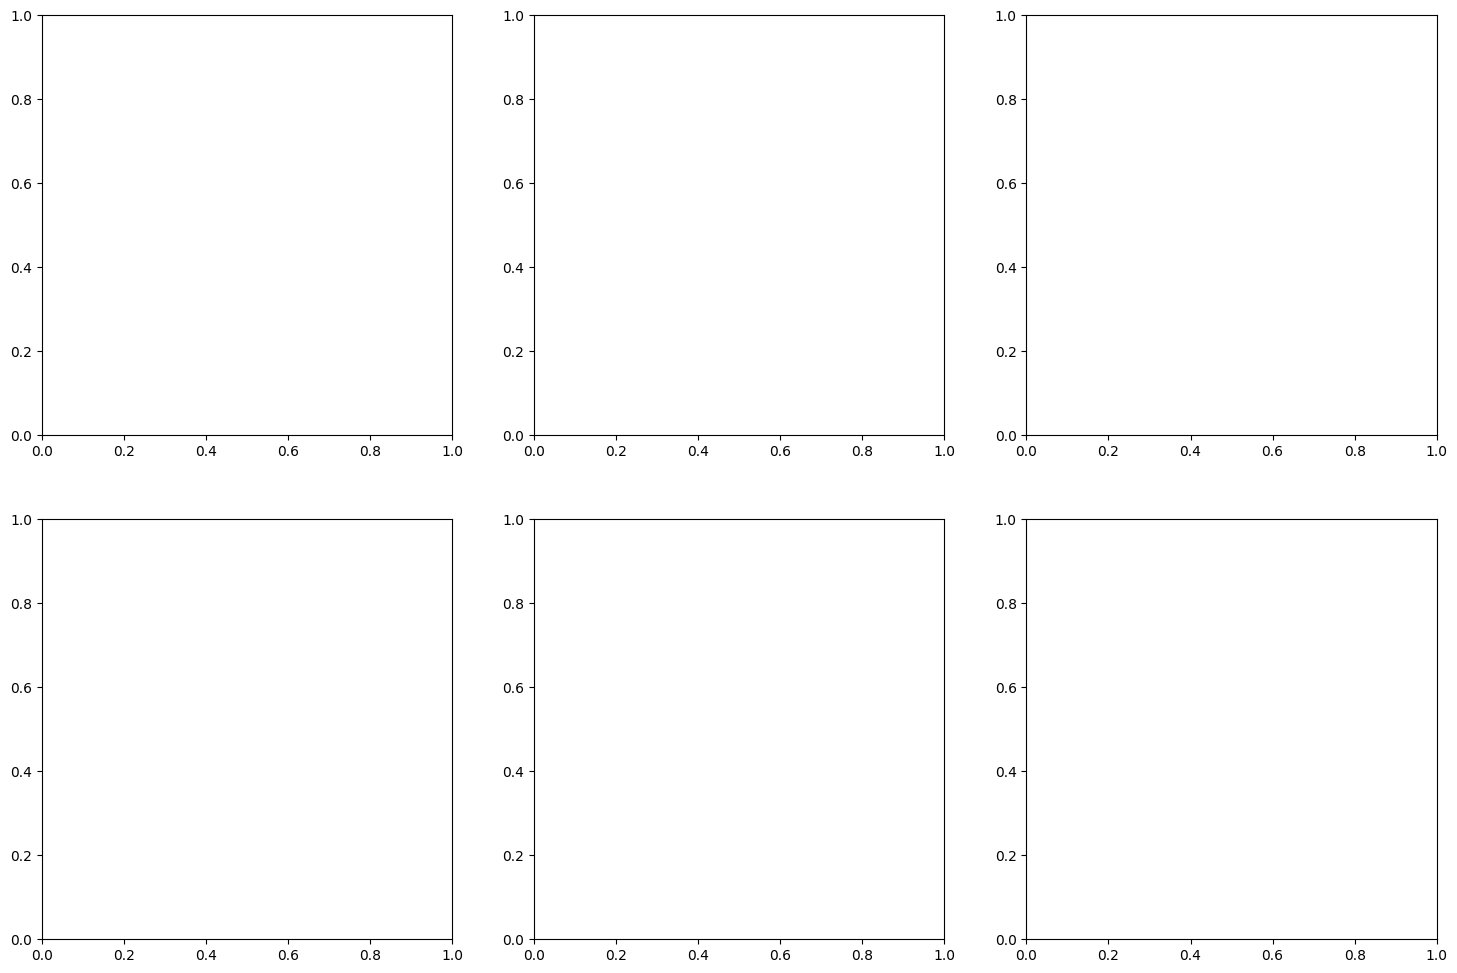

In [14]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import time
from geosketch import gs
from sklearn.cluster import KMeans
import hashlib
import sketchKH

# Load and preprocess the dataset
adata = sc.read_10x_mtx("filtered_matrices_mex/hg19/", var_names='gene_symbols', make_unique=True)
print(f"Loaded dataset with {adata.n_obs} cells and {adata.n_vars} genes.")

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)

# Scale and perform PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
X_pca = adata.obsm['X_pca']

# Compute neighbors and clustering
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata, min_dist=0.5)
full_labels = adata.obs['leiden'].copy()
X_umap = adata.obsm['X_umap']

# Identify rare cluster
cluster_counts = adata.obs['leiden'].value_counts()
rare_cluster = cluster_counts.idxmin()
rare_count = cluster_counts.min()
print(f"Rare cluster is {rare_cluster} with {rare_count} cells.")

# Define sketch size
N = 1000

# Initialize dictionaries to store results
methods = {}
subset_adatas = {}
rare_capture = {}
times = {}

# 1. Random Sampling
start = time.time()
np.random.seed(42)
uniform_indices = np.random.choice(adata.n_obs, size=N, replace=False)
end = time.time()
methods['Random'] = uniform_indices
subset_adatas['Random'] = adata[uniform_indices].copy()
times['Random'] = end - start
rare_labels = adata.obs['leiden'].iloc[uniform_indices]
rare_capture['Random'] = (rare_labels == rare_cluster).sum()

# 2. Geometric Sketching
start = time.time()
sketch_indices = gs(X_pca, N, replace=False)
end = time.time()
methods['Geometric'] = sketch_indices
subset_adatas['Geometric'] = adata[sketch_indices].copy()
times['Geometric'] = end - start
rare_labels = adata.obs['leiden'].iloc[sketch_indices]
rare_capture['Geometric'] = (rare_labels == rare_cluster).sum()

# 3. K-Means Medoids
start = time.time()
kmeans = KMeans(n_clusters=N, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
centers = kmeans.cluster_centers_
medoid_indices = []
for i in range(N):
    cluster_idx = np.where(cluster_labels == i)[0]
    if cluster_idx.size == 0:
        continue
    dist = np.sum((X_pca[cluster_idx] - centers[i])**2, axis=1)
    closest = cluster_idx[np.argmin(dist)]
    medoid_indices.append(closest)
end = time.time()
methods['KMeans'] = medoid_indices
subset_adatas['KMeans'] = adata[medoid_indices].copy()
times['KMeans'] = end - start
rare_labels = adata.obs['leiden'].iloc[medoid_indices]
rare_capture['KMeans'] = (rare_labels == rare_cluster).sum()

# 4. Kernel Herding
start = time.time()
adata_kh = sketchKH(adata=adata, sample_set_key=None, sketch_size=N, gamma=1.0, frequency_seed=42)
kh_indices = [adata.obs_names.get_loc(name) for name in adata_kh.obs_names]
end = time.time()
methods['Kernel Herding'] = kh_indices
subset_adatas['Kernel Herding'] = adata[kh_indices].copy()
times['Kernel Herding'] = end - start
rare_labels = adata.obs['leiden'].iloc[kh_indices]
rare_capture['Kernel Herding'] = (rare_labels == rare_cluster).sum()

# 5. Hashing-Based Sampling
start = time.time()
cell_ids = adata.obs_names
hash_values = [int(hashlib.md5(cell_id.encode()).hexdigest(), 16) for cell_id in cell_ids]
sorted_indices = np.argsort(hash_values)
hash_indices = sorted_indices[:N]
end = time.time()
methods['Hashing'] = hash_indices
subset_adatas['Hashing'] = adata[hash_indices].copy()
times['Hashing'] = end - start
rare_labels = adata.obs['leiden'].iloc[hash_indices]
rare_capture['Hashing'] = (rare_labels == rare_cluster).sum()

# 6. PCA-Weighted Sampling
start = time.time()
variances = np.var(X_pca, axis=1)
probabilities = variances / np.sum(variances)
pca_indices = np.random.choice(len(X_pca), size=N, replace=False, p=probabilities)
end = time.time()
methods['PCA-Weighted'] = pca_indices
subset_adatas['PCA-Weighted'] = adata[pca_indices].copy()
times['PCA-Weighted'] = end - start
rare_labels = adata.obs['leiden'].iloc[pca_indices]
rare_capture['PCA-Weighted'] = (rare_labels == rare_cluster).sum()

# Plot UMAPs for each method
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for ax, (name, idx) in zip(axes, methods.items()):
    ax.scatter(X_umap[:, 0], X_um)
               
 


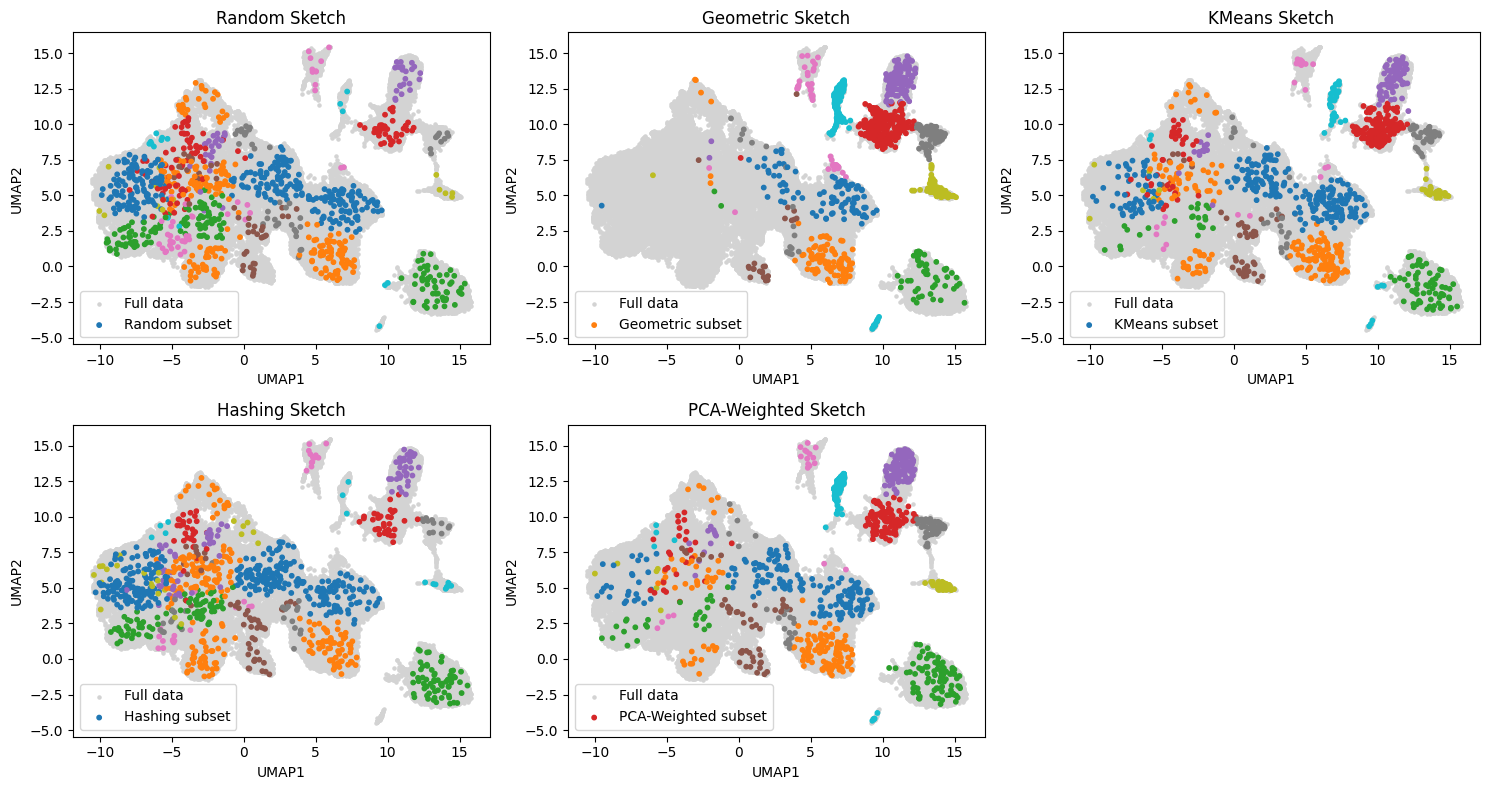

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'methods' is a dictionary with method names as keys and indices as values
# 'X_umap' contains UMAP coordinates for all cells
# 'full_labels' contains cluster labels for all cells

# Define the number of methods
num_methods = len(methods)
# Determine the number of rows and columns for subplots
ncols = 3
nrows = int(np.ceil(num_methods / ncols))

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Plot UMAP for each method
for ax, (name, idx) in zip(axes, methods.items()):
    # Plot full data in light grey
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c='lightgrey', s=5, label='Full data')
    # Plot subset points colored by full cluster labels
    colors = full_labels.cat.codes.iloc[idx]  # Ensure 'idx' is used to index into 'full_labels'
    scatter = ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=colors, cmap='tab10', s=10, label=f'{name} subset')
    ax.set_title(f"{name} Sketch")
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend()

# Hide any unused subplots
for i in range(len(methods), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


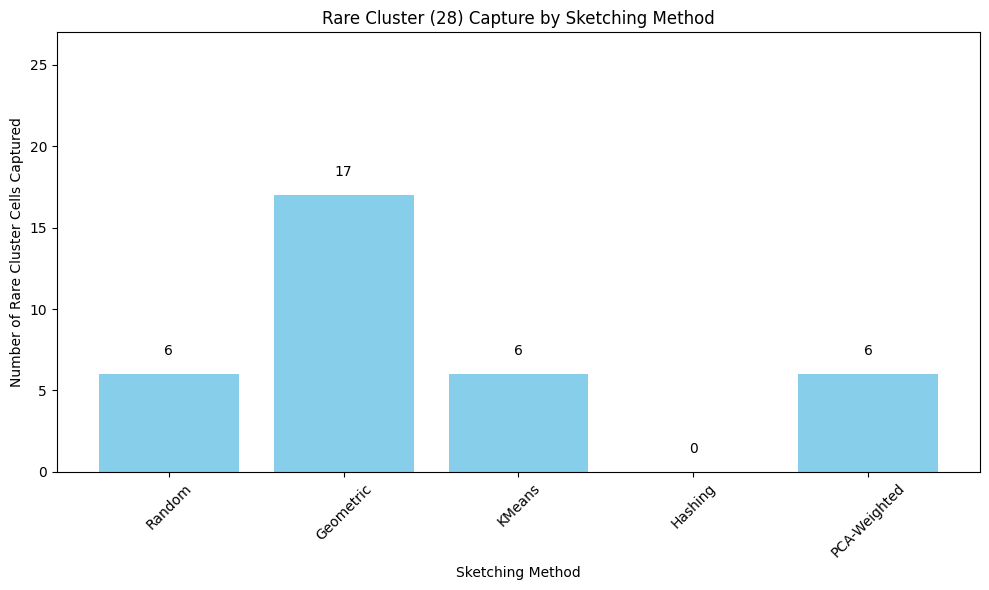

In [17]:
# Assuming 'rare_capture' is a dictionary with method names as keys and counts as values

# Extract method names and corresponding rare cluster counts
method_names = list(rare_capture.keys())
rare_counts = list(rare_capture.values())

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(method_names, rare_counts, color='skyblue')
plt.xlabel('Sketching Method')
plt.ylabel('Number of Rare Cluster Cells Captured')
plt.title(f'Rare Cluster ({rare_cluster}) Capture by Sketching Method')
plt.xticks(rotation=45)
plt.ylim(0, max(rare_counts) + 10)

# Annotate bars with counts
for bar, count in zip(bars, rare_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()
